In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.layers import Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Masking
from keras.layers import LSTM

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Curl counter variables
counter = 0 
stage = None

def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

# Directory containing videos
video_dir = 'C:/Users/Monika/Desktop/cropped_exercises'

squat_videos = [
    "squat_2.mp4",
    "squat_3.mp4",
    "squat_4.mp4",
    "squat_5.mp4",
    "squat_6.mp4",
    "squat_7.mp4",
    "squat_8.mp4",
    "squat_9.mp4",
    "squat_10.mp4",
    "squat_11.mp4",
    "squat_12.mp4",
    "squat_13.mp4",
    "squat_14.mp4",
    "squat_15.mp4",
    "squat_16.mp4",
    "squat_17.mp4",
    "squat_18.mp4",
    "squat_19.mp4",
    "squat_20.mp4",
    "squat_21.mp4",
    "squat_22.mp4",
    "squat_23.mp4",
    "squat_24.mp4",
    "squat_25.mp4",
    "squat_26.mp4",
    "squat_27.mp4",
    "squat_28.mp4",
    "squat_29.mp4",
    "squat_1.mp4",
     "squat30.mp4", "squat31.mp4", "squat32.mp4", "squat33.mp4", "squat34.mp4", "squat35.mp4", "squat36.mp4", "squat37.mp4",
     "squat38.mp4", "squat39.mp4", "squat40.mp4", "squat41.mp4", "squat42.mp4",
]

jumping_jack_videos = [
    "jumping_jack2.mp4",
    "jumping_jack3.mp4",
    "jumping_jack4.mp4",
    "jumping_jack5.mp4",
    "jumping_jack6.mp4",
    "jumping_jack7.mp4",
    "jumping_jack8.mp4",
    "jumping_jack1.mp4",
    "jumping_jack9.mp4","jumping_jack10.mp4","jumping_jack11.mp4","jumping_jack12.mp4","jumping_jack13.mp4","jumping_jack14.mp4",
    "jumping_jack15.mp4","jumping_jack16.mp4","jumping_jack17.mp4","jumping_jack18.mp4","jumping_jack19.mp4","jumping_jack20.mp4",
    "jumping_jack21.mp4","jumping_jack22.mp4","jumping_jack23.mp4","jumping_jack24.mp4","jumping_jack25.mp4","jumping_jack26.mp4",
    "jumping_jack27.mp4","jumping_jack28.mp4","jumping_jack29.mp4","jumping_jack30.mp4","jumping_jack31.mp4","jumping_jack32.mp4",
    "jumping_jack33.mp4","jumping_jack34.mp4","jumping_jack35.mp4","jumping_jack36.mp4","jumping_jack37.mp4","jumping_jack38.mp4",
    "jumping_jack39.mp4","jumping_jack40.mp4","jumping_jack41.mp4","jumping_jack42.mp4","jumping_jack43.mp4","jumping_jack44.mp4","jumping_jack45.mp4",
]

rest_videos=[
    "rest1.mp4","rest2.mp4","rest3.mp4","rest4.mp4","rest5.mp4","rest6.mp4","rest7.mp4","rest8.mp4","rest9.mp4","rest10.mp4",
    "rest11.mp4","rest12.mp4","rest13.mp4","rest14.mp4","rest15.mp4","rest16.mp4","rest17.mp4","rest18.mp4","rest19.mp4","rest20.mp4",
    "rest21.mp4","rest22.mp4","rest23.mp4","rest24.mp4","rest25.mp4","rest26.mp4","rest27.mp4","rest28.mp4","rest29.mp4",
    "rest30.mp4","rest31.mp4","rest32.mp4","rest33.mp4","rest34.mp4","rest35.mp4","rest36.mp4","rest37.mp4","rest38.mp4","rest39.mp4",
    "rest40.mp4","rest41.mp4","rest42.mp4",
    

]


# Get a list of video files
video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.mov'))]

# Dictionary to store angles from each video
video_angles = {}
labels={}
## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    for video_file in video_files:
        cap = cv2.VideoCapture(os.path.join(video_dir, video_file))
        arms_legs=[]
        angles = []

        curl_angles=[]
        lateral_angles=[]

        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
      
            # Make detection
            results = pose.process(image)
        
            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                
                # Get coordinates
                shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
                wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]


                left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
                right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
                left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
                right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
                
                right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
                
                # Calculate angle
                angle_elbow = calculate_angle(shoulder, elbow, wrist)

                # Get coordinates for the second angle (hip, shoulder, elbow)
                hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
                right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
                # shoulder and elbow coordinates are already available

                # Calculate the second angle
                angle_shoulder = calculate_angle(hip, shoulder, elbow)

                angle_feet=calculate_angle(right_ankle,right_knee,left_ankle)

                angle_knee=calculate_angle(right_ankle,right_knee,right_hip)


                # Append both angles to the list
                angles.append([angle_elbow, angle_shoulder,angle_feet,angle_knee])

                           
            except:
                pass
            
        # Store angles from this video
        video_angles[video_file] = angles
       


        if video_file in jumping_jack_videos:
            labels[video_file] = 1
        else:
            labels[video_file] = 0


        print(video_file)
        cap.release()

cv2.destroyAllWindows()




barbell_bicepcurl1.mp4
barbell_bicepcurl10.mp4
barbell_bicepcurl11.mp4
barbell_bicepcurl12.mp4
barbell_bicepcurl13.mp4
barbell_bicepcurl14.mp4
barbell_bicepcurl15.mp4
barbell_bicepcurl16.mp4
barbell_bicepcurl17.mp4
barbell_bicepcurl18.mp4
barbell_bicepcurl19.mp4
barbell_bicepcurl2.mp4
barbell_bicepcurl20.mp4
barbell_bicepcurl21.mp4
barbell_bicepcurl22.mp4
barbell_bicepcurl23.mp4
barbell_bicepcurl24.mp4
barbell_bicepcurl25.mp4
barbell_bicepcurl26.mp4
barbell_bicepcurl27.mp4
barbell_bicepcurl28.mp4
barbell_bicepcurl29.mp4
barbell_bicepcurl3.mp4
barbell_bicepcurl30.mp4
barbell_bicepcurl31.mp4
barbell_bicepcurl32.mp4
barbell_bicepcurl33.mp4
barbell_bicepcurl34.mp4
barbell_bicepcurl35.mp4
barbell_bicepcurl36.mp4
barbell_bicepcurl37.mp4
barbell_bicepcurl38.mp4
barbell_bicepcurl39.mp4
barbell_bicepcurl4.mp4
barbell_bicepcurl40.mp4
barbell_bicepcurl41.mp4
barbell_bicepcurl42.mp4
barbell_bicepcurl43.mp4
barbell_bicepcurl44.mp4
barbell_bicepcurl5.mp4
barbell_bicepcurl6.mp4
barbell_bicepcurl7.mp

Epoch 1/100
4/4 [==============================] - 5s 561ms/step - loss: 0.7053 - accuracy: 0.6000 - val_loss: 0.5735 - val_accuracy: 0.7143
Epoch 2/100
4/4 [==============================] - 0s 42ms/step - loss: 0.7229 - accuracy: 0.6182 - val_loss: 0.5287 - val_accuracy: 0.7143
Epoch 3/100
4/4 [==============================] - 0s 44ms/step - loss: 0.5554 - accuracy: 0.7000 - val_loss: 0.4993 - val_accuracy: 0.7143
Epoch 4/100
4/4 [==============================] - 0s 41ms/step - loss: 0.5606 - accuracy: 0.7364 - val_loss: 0.4664 - val_accuracy: 0.7143
Epoch 5/100
4/4 [==============================] - 0s 39ms/step - loss: 0.5475 - accuracy: 0.7182 - val_loss: 0.4350 - val_accuracy: 0.7143
Epoch 6/100
4/4 [==============================] - 0s 41ms/step - loss: 0.5728 - accuracy: 0.7182 - val_loss: 0.4200 - val_accuracy: 0.8214
Epoch 7/100
4/4 [==============================] - 0s 41ms/step - loss: 0.5365 - accuracy: 0.7091 - val_loss: 0.3935 - val_accuracy: 0.9643
Epoch 8/100
4/4 [==

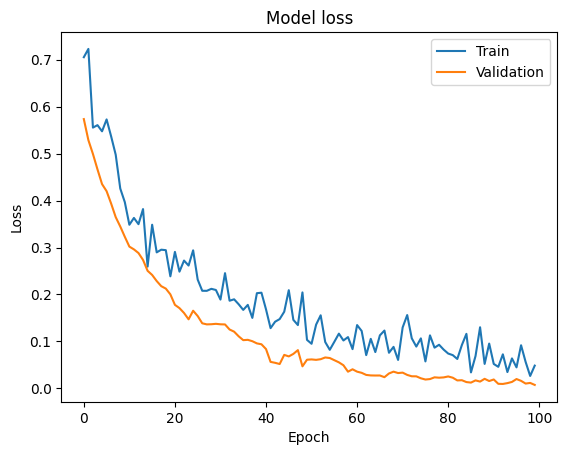

In [3]:
import matplotlib.pyplot as plt
# Prepare your data
X = pad_sequences([video_angles[video] for video in video_files], padding='post')
y = np.array([labels[video] for video in video_files])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(None, 4)))  # Add Masking layer
model.add(LSTM(64, return_sequences=False))  # LSTM layer
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Change this line to account for the new category

# Compile the model
model.compile(loss='binary_crossentropy',  # Binary crossentropy for binary classification
              optimizer='rmsprop',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
score = model.evaluate(X_test, y_test, batch_size=10)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
